# Importing Required Packages

In [15]:
# Data Manipulation
import numpy as np
from collections import namedtuple

# Loading Pre-trained Model
from keras.models import model_from_json
import urllib.request, json 

# Displaying Images
import matplotlib.pyplot as plt

# Image Processing
import cv2
import imutils
import tensorflow

# Aligning Images

In [16]:
def align_imgs(imgGray, templateGray, maxFeatures = 1500, keepPercent = 0.2):
  # Key Point and Descriptors for "imgGray" and "templateGray"
  orb = cv2.ORB_create(maxFeatures)
  (kpsA, descsA) = orb.detectAndCompute(imgGray, None)
  (kpsB, descsB) = orb.detectAndCompute(templateGray, None)

  # Key point matching based on descriptors
  matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
  matches = matcher.match(descsA, descsB)
  matches = sorted(matches, key=lambda x:x.distance)

  # Filtering strongly matched Keypoints
  keep = int(len(matches) * keepPercent)
  matches = matches[:keep]

  # Drawing Matching Points
  matchedVis = cv2.drawMatches(imgGray, kpsA, templateGray, kpsB, matches, None)
  matchedVis = imutils.resize(matchedVis, width=1000)

  # Points for Warping
  ptsA = np.zeros((len(matches), 2), dtype="float")
  ptsB = np.zeros((len(matches), 2), dtype="float")

  for (i, m) in enumerate(matches):
    ptsA[i] = kpsA[m.queryIdx].pt
    ptsB[i] = kpsB[m.trainIdx].pt

  # Warp Matrix
  (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)

  # Warping
  (h, w) = templateGray.shape[:2]
  aligned = cv2.warpPerspective(imgGray, H, (w, h))

  return [imgGray, templateGray, matchedVis, aligned]

# Predicting Text for a ROI

In [17]:
def pred_txt_roi(img, cordinates, nob, bt, model, trim=0.2, th=0.2):
    (x, y, X, Y) = cordinates
    labelNames = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    labelNames = [l for l in labelNames]

    result = ""
    max_sum = 0

    # Metrics counters
    correct_detections = 0
    missed_detections = 0
    false_detections = 0

    for i in range(nob):
        sep = 3 * int(bool(i))
        c1 = bt*i + sep*i
        c2 = bt*(i+1) + sep*i

        roi = img[y:Y, (x+c1):(x+c2)]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape
        if tW > tH:
            thresh = imutils.resize(thresh, width=32)
        else:
            thresh = imutils.resize(thresh, height=32)
            
        (tH, tW) = thresh.shape
        dX = int(max(0, 32 - tW) / 2.0)
        dY = int(max(0, 32 - tH) / 2.0)
        padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY, 
                                    left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, 
                                    value=(0, 0, 0))
        padded = cv2.resize(padded, (32, 32))
        padded = padded.astype("float32") / 255.0
        padded_reshaped = np.expand_dims(np.expand_dims(padded, axis=-1), axis=0)

        pred = model.predict(padded_reshaped)
        p = np.argmax(pred)
        prob = pred[:, p]
        label = labelNames[p]

        sum = np.sum(padded[int(trim*32):int(-trim*32), int(trim*32):int(-trim*32)])
        if sum > max_sum:
            max_sum = sum
        if sum >= th*max_sum:
            result = result + label

            # Assuming you have ground truth for each character, you could compare it here.
            if label == ground_truth[i]:  # ground_truth is an array of the correct characters
                correct_detections += 1
            else:
                false_detections += 1
        else:
            missed_detections += 1

    return result, correct_detections, missed_detections, false_detections


# Predict Tick for a ROI

In [18]:
def pred_tick_roi(img, cordinates, trim = 0.2):
  x, y, X, Y = cordinates
  
  roi = img[y:Y, x:X]
  H, W = roi.shape

  roi_trim = roi[int(trim*H):-int(trim*H), int(trim*W):-int(trim*W)]
  thresh = cv2.threshold(roi_trim, 127, 255, cv2.THRESH_BINARY_INV)[1]

  if np.sum(thresh) != 0:
    return "Yes"
    return "No"

# Load Handwriting Recognition Model

In [24]:
model_path = "/content/drive/MyDrive/OpenCV Tutorial/Final SBI assignment/Resnet/model.h5"

from tensorflow.keras.models import load_model

# Load the entire model (architecture + weights + optimizer)
model = load_model("model.h5")

# Reading Images

Size of Templates
Page 1 -  (1754, 1241)
Page 2 -  (1754, 1241)

Size of Scanned Images
Page 1 -  (1755, 1241)
Page 2 -  (1755, 1241)


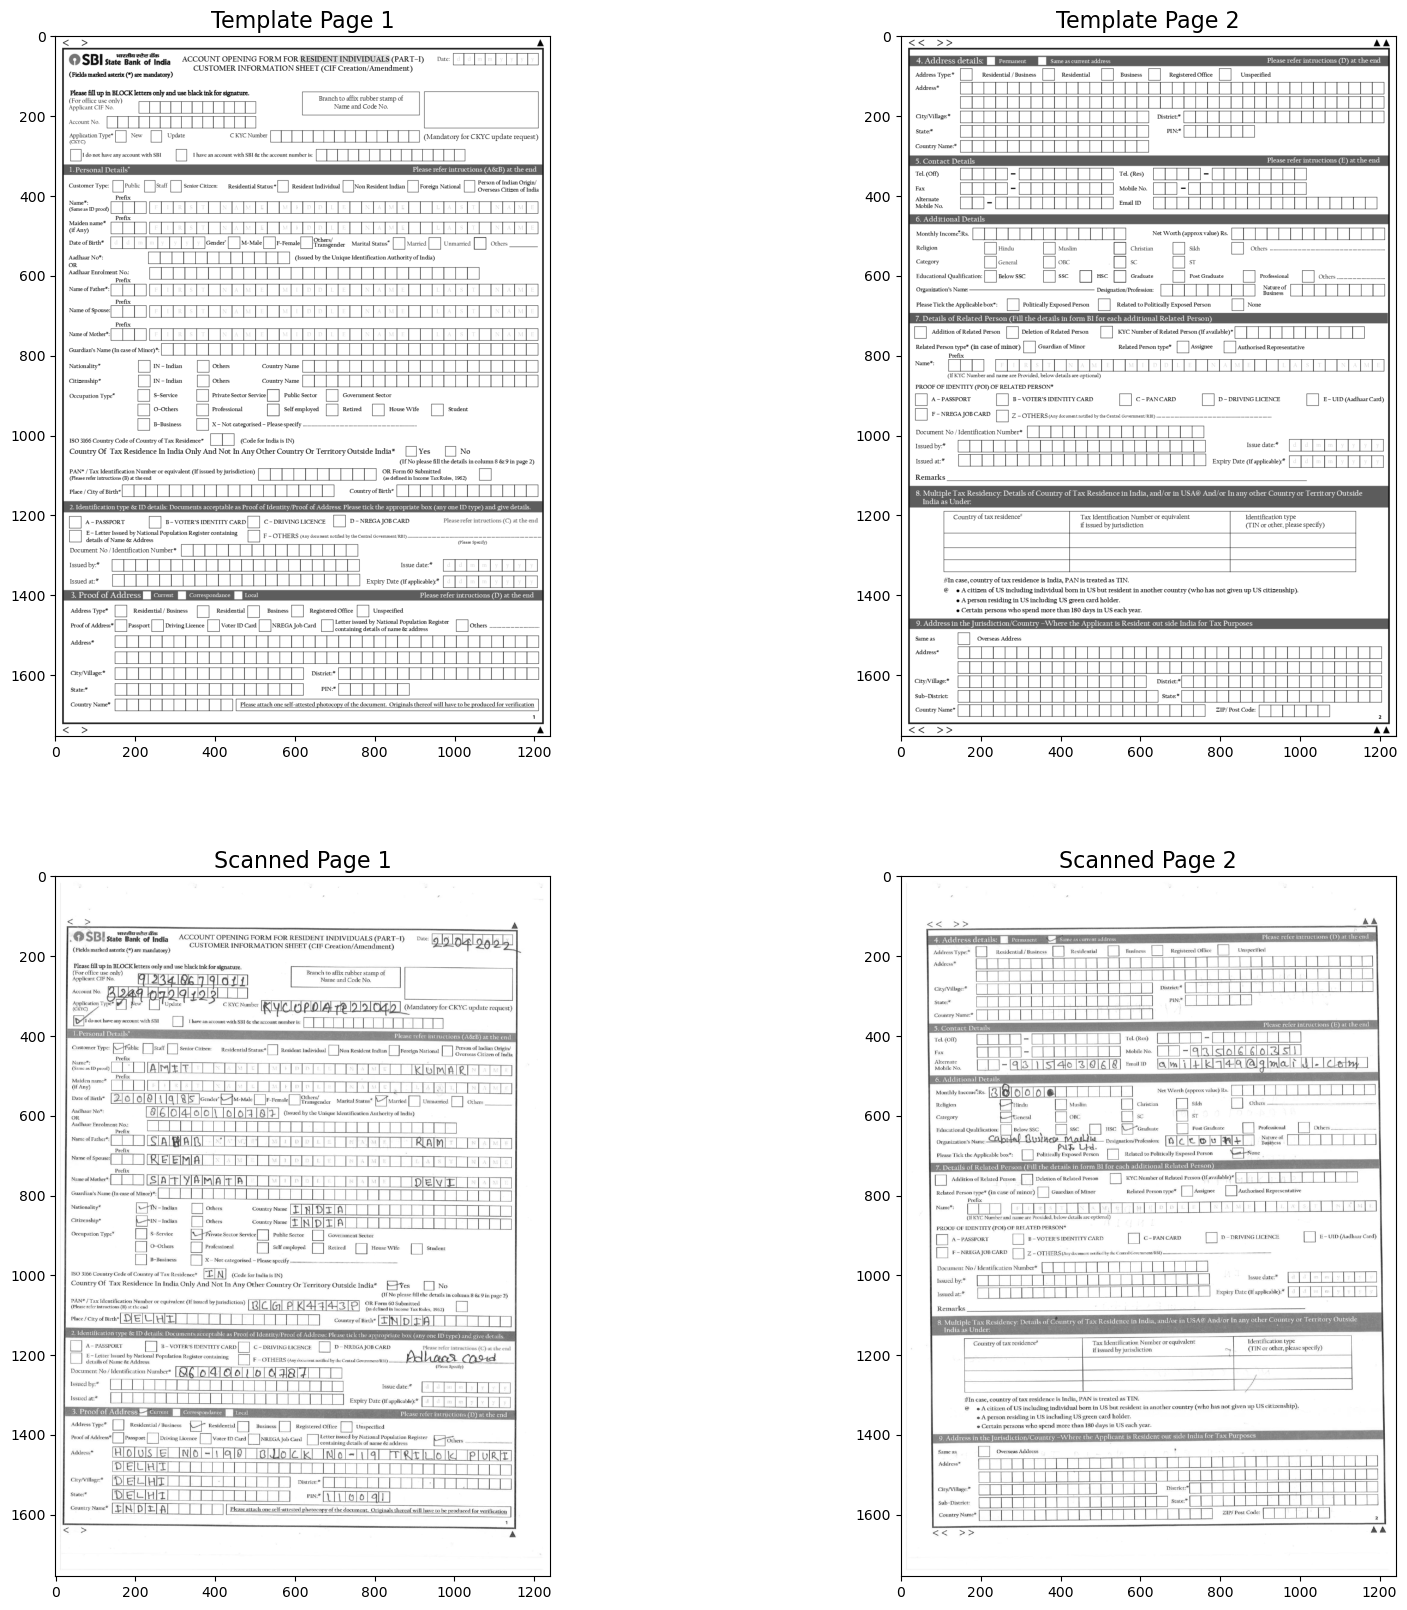

In [20]:
# Load Template Images
# These are in my Google Drive
# They are the same files as the ones stored in the Template directory in the github repo
template_1_path = "C:\\Users\\DELL\\OneDrive\\Pictures\\Camera Roll\\ACCOUNT_OPENING_FORM_FOR_RESIDENT_INDIVI_page-0001.jpg"
template_2_path = "C:\\Users\\DELL\\OneDrive\\Pictures\\Camera Roll\\ACCOUNT_OPENING_FORM_FOR_RESIDENT_INDIVI_page-0002.jpg"

template_1 = cv2.imread(template_1_path)
template_1_gray = cv2.cvtColor(template_1, cv2.COLOR_BGR2GRAY)

template_2 = cv2.imread(template_2_path)
template_2_gray = cv2.cvtColor(template_2, cv2.COLOR_BGR2GRAY)

print("Size of Templates")
print("Page 1 - ", template_1_gray.shape)
print("Page 2 - ", template_2_gray.shape)


# Load Scaned Images
# These are in my Google Drive
# They are the same files as the ones stored in the Scan directory in the github rep
scan_1_path = "C:\\Users\\DELL\\OneDrive\\New folder\\32490729123_page-0002.jpg"
scan_2_path = "C:\\Users\\DELL\\OneDrive\\New folder\\32490729123_page-0003.jpg"

scan_1 = cv2.imread(scan_1_path)
scan_1_gray = cv2.cvtColor(scan_1, cv2.COLOR_BGR2GRAY)

scan_2 = cv2.imread(scan_2_path)
scan_2_gray = cv2.cvtColor(scan_2, cv2.COLOR_BGR2GRAY)

print("\nSize of Scanned Images")
print("Page 1 - ", scan_1_gray.shape)
print("Page 2 - ", scan_2_gray.shape)


# Plotting Images
fig, ax = plt.subplots(2, 2, figsize = (20, 20))

ax[0, 0].imshow(template_1_gray, cmap = "gray")
ax[0, 0].set_title("Template Page 1", size = 16)
ax[0, 1].imshow(template_2_gray, cmap = "gray")
ax[0, 1].set_title("Template Page 2", size = 16)

ax[1, 0].imshow(scan_1_gray, cmap = "gray")
ax[1, 0].set_title("Scanned Page 1", size = 16)
ax[1, 1].imshow(scan_2_gray, cmap = "gray")
ax[1, 1].set_title("Scanned Page 2", size = 16)

plt.show()

# Aligning Scanned Images With Template

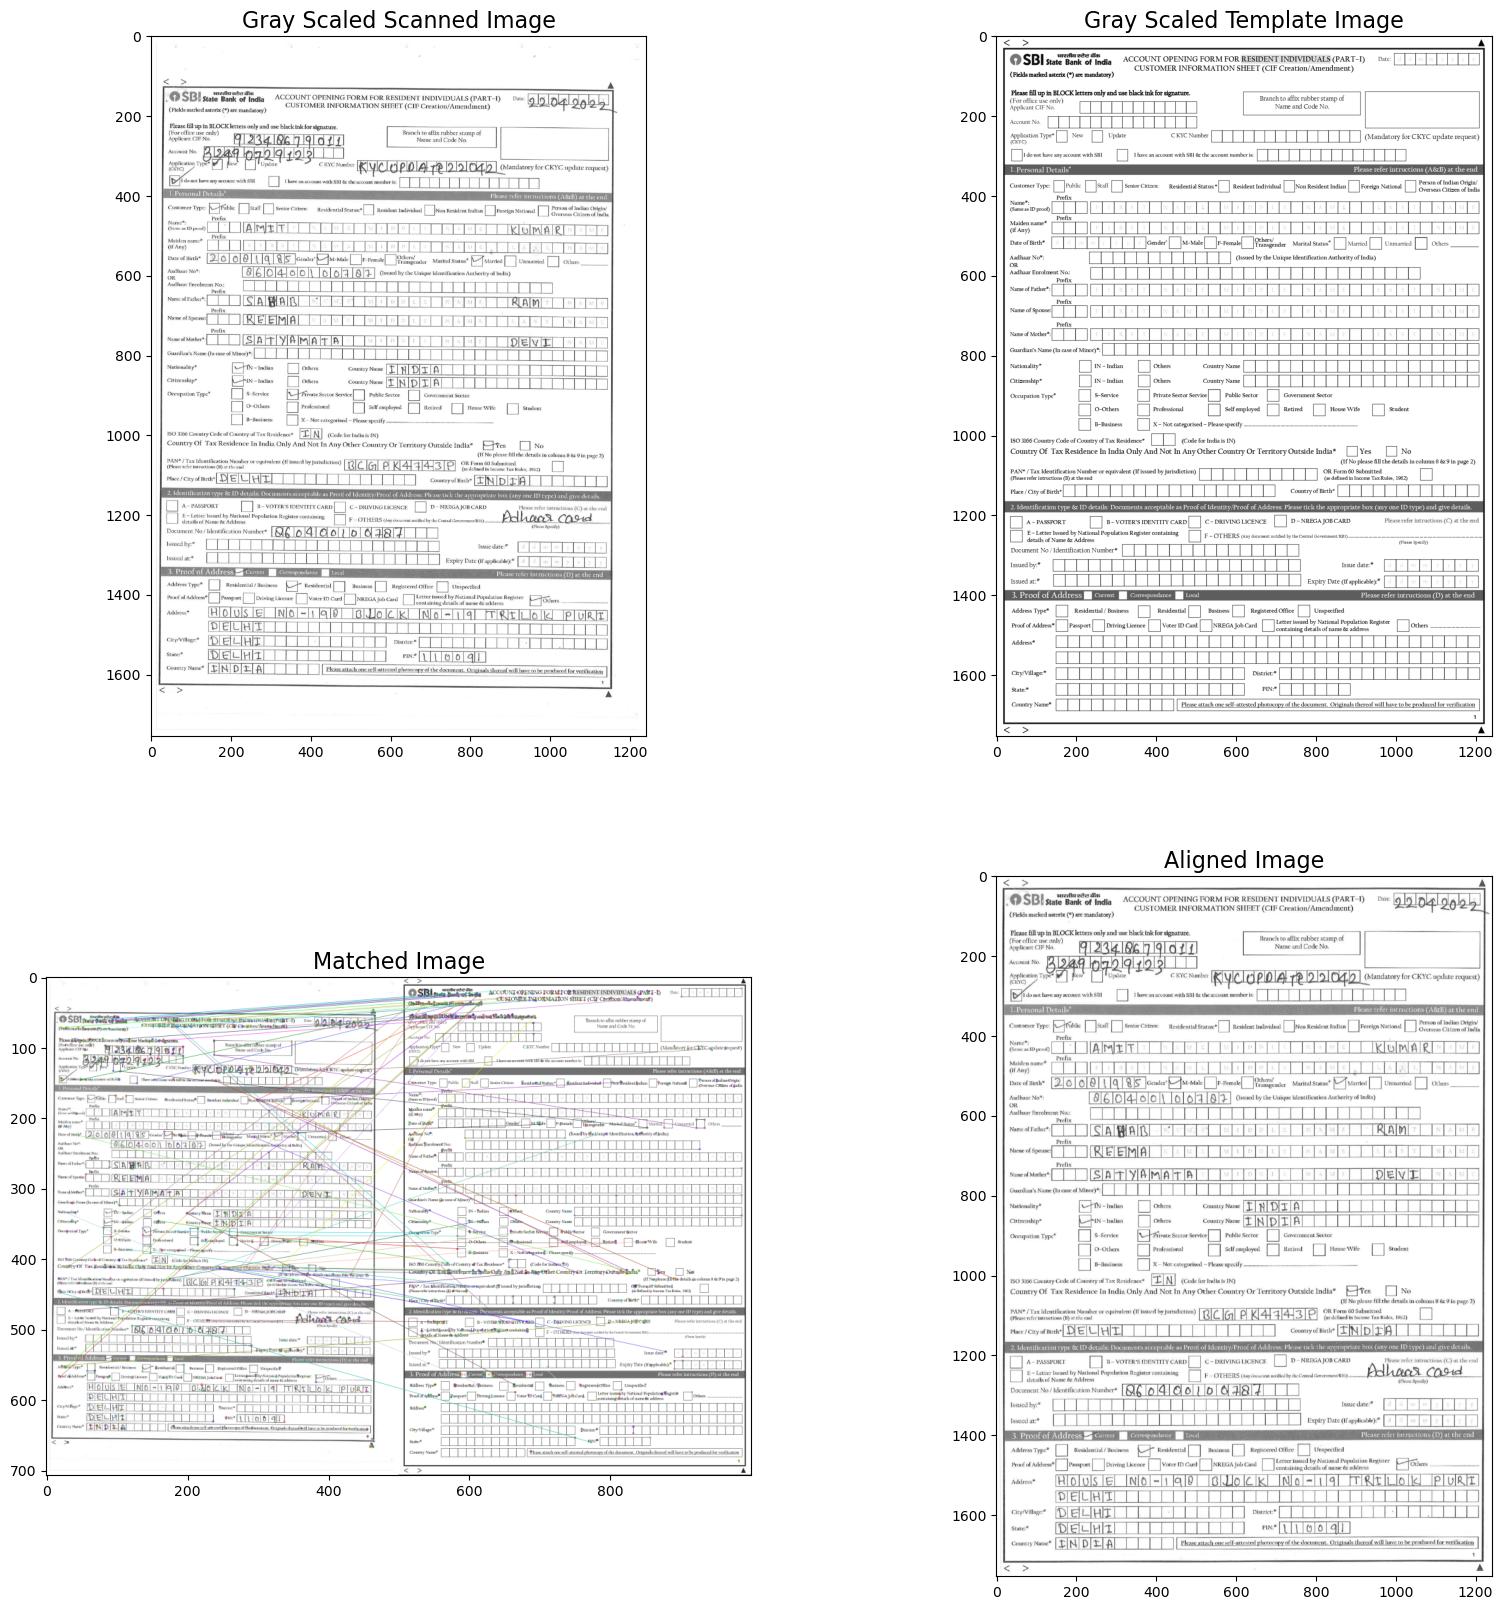

In [21]:
(scan_1_gray, template_1_gray, matched_1, aligned_1) = align_imgs(scan_1_gray, template_1_gray, maxFeatures = 1500, keepPercent = 0.2)

fig, ax = plt.subplots(2, 2, figsize = (20, 20))

ax[0, 0].imshow(scan_1_gray, cmap = "gray")
ax[0, 0].set_title("Gray Scaled Scanned Image", size = 16)

ax[0, 1].imshow(template_1_gray, cmap = "gray")
ax[0, 1].set_title("Gray Scaled Template Image", size = 16)

ax[1, 0].imshow(matched_1, cmap = "gray")
ax[1, 0].set_title("Matched Image", size = 16)

ax[1, 1].imshow(aligned_1, cmap = "gray")
ax[1, 1].set_title("Aligned Image", size = 16)

plt.show()

# For pages

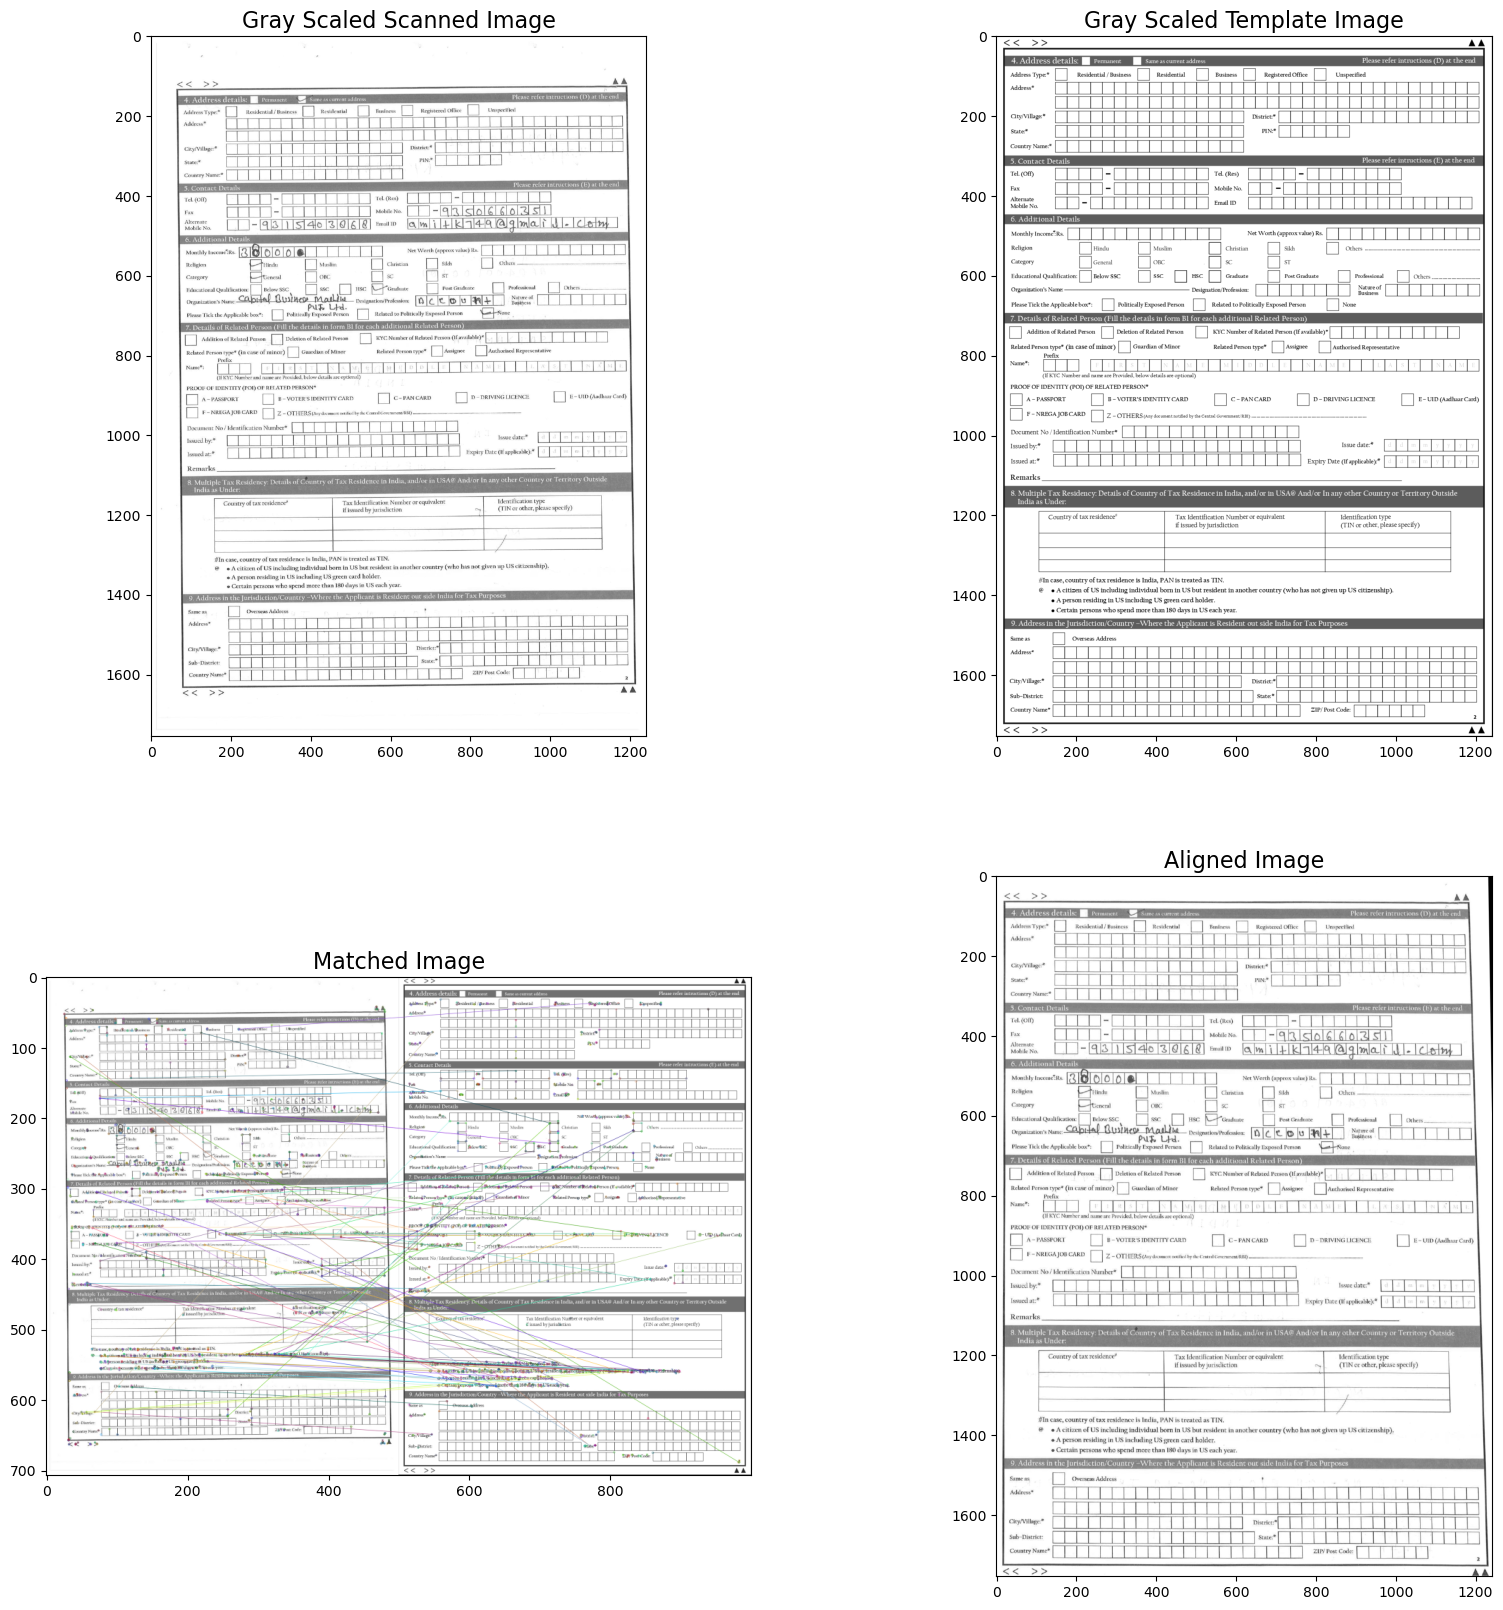

In [11]:
(scan_2_gray, template_2_gray, matched_2, aligned_2) = align_imgs(scan_2_gray, 
                                                                  template_2_gray, 
                                                                  maxFeatures = 1500, 
                                                                  keepPercent = 0.2)

fig, ax = plt.subplots(2, 2, figsize = (20, 20))

ax[0, 0].imshow(scan_2_gray, cmap = "gray")
ax[0, 0].set_title("Gray Scaled Scanned Image", size = 16)

ax[0, 1].imshow(template_2_gray, cmap = "gray")
ax[0, 1].set_title("Gray Scaled Template Image", size = 16)

ax[1, 0].imshow(matched_2, cmap = "gray")
ax[1, 0].set_title("Matched Image", size = 16)

ax[1, 1].imshow(aligned_2, cmap = "gray")
ax[1, 1].set_title("Aligned Image", size = 16)

plt.show()

In [22]:
print("Aligned Scaned Images")
print("Page 1: ", aligned_1.shape)
print("Page 2: ", aligned_2.shape)

print("\nTemplate Images")
print("Page 1: ", template_1_gray.shape)
print("Page 2: ", template_2_gray.shape)

Aligned Scaned Images
Page 1:  (1754, 1241)
Page 2:  (1754, 1241)

Template Images
Page 1:  (1754, 1241)
Page 2:  (1754, 1241)


# "PROPOSER DETAILS" Section

In [12]:
OCRTicks = namedtuple("OCRTicks", ["id", "bbox", "trim"])

OCR_TICKS = [
  OCRTicks("Gender:Male",     (125, 468, 149, 493), 0.2),
  OCRTicks("Gender:Female",   (219, 468, 243, 493), 0.2),
  OCRTicks("Gender:Other",    (335, 468, 360, 493), 0.2),
]

tick_results_dict = dict()
for ocr_tick in OCR_TICKS:
  id, bbox, trim = ocr_tick
  txt = pred_tick_roi(aligned_1, bbox, trim = trim)
  tick_results_dict[id] = txt

print("RESULTS")
for key, value in tick_results_dict.items():
  print(str(key) + ": " + str(value))

RESULTS
Gender:Male: Yes
Gender:Female: Yes
Gender:Other: None


# Text Fields

In [25]:
from collections import namedtuple
OCRLocation = namedtuple("OCRLocation", ["id", "bbox", "nob", "bt", "trim", "th"])

OCR_LOCATIONS = [
  OCRLocation("Title",        (128, 445, 220, 460),   4,  21, 0.2, 0.2),
  OCRLocation("Name",         (287, 440, 1191, 459),  38, 21, 0.3, 0.2),
  OCRLocation("DOB",          (570, 470, 765, 487),   8,  21, 0.3, 0.20),
  OCRLocation("Contact",      (849, 470, 1191, 487),  14, 21, 0.3, 0.2),
  OCRLocation("Email",        (123, 498, 765, 520),   27, 21, 0.4, 0.4),
  OCRLocation("Mobile",       (846, 500, 1191, 515),  14, 21, 0.3, 0.2),
  OCRLocation("Occupation",   (219, 525, 789, 544),   24, 20, 0.3, 0.2),
  OCRLocation("DOB_proposer", (219, 557, 411, 572),   8,  21, 0.3, 0.2),
  OCRLocation("PAN",          (893, 557, 1191, 571),  12, 21, 0.3, 0.2),
  OCRLocation("House",        (218, 583, 483, 598),   11, 21, 0.3, 0.4),
  OCRLocation("Block",        (544, 583, 836, 598),   12, 21, 0.3, 0.6),
  OCRLocation("Building",     (890, 582, 1191, 600),  12, 21, 0.3, 0.3),
  OCRLocation("Locality",     (216, 608, 475, 627),   11, 21, 0.3, 0.3),
  OCRLocation("Street",       (540, 608, 823, 627),   12, 21, 0.3, 0.3),
  OCRLocation("City",         (891, 608, 1191, 627),  12, 21, 0.3, 0.3),
  OCRLocation("State",        (215, 636, 754, 656),   23, 20, 0.3, 0.5),
  OCRLocation("Pincode",      (842, 636, 983, 656),   6,  21, 0.2, 0.2),
  OCRLocation("Country",      (1050, 636, 1191, 656), 5,  20, 0.2, 0.2),
]

results_dict = dict()
for ocr_loc in OCR_LOCATIONS:
  id, bbox, nob, bt, trim, th = ocr_loc
  txt = pred_txt_roi(aligned_1, bbox, nob, bt,model, trim = trim, th = th)
  results_dict[id] = txt

print("RESULTS")
for key, value in results_dict.items():
  print(str(key) + ": " + str(value))
correct_detections_total = 0
missed_detections_total = 0
false_detections_total = 0

for ocr_loc in OCR_LOCATIONS:
    id, bbox, nob, bt, trim, th = ocr_loc
    result, correct, missed, false = pred_txt_roi(aligned_1, bbox, nob, bt, model, trim=trim, th=th)
    results_dict[id] = result

    correct_detections_total += correct
    missed_detections_total += missed
    false_detections_total += false

# Calculate accuracy
total_detections = correct_detections_total + missed_detections_total + false_detections_total
accuracy = correct_detections_total / total_detections if total_detections > 0 else 0

print("RESULTS")
for key, value in results_dict.items():
    print(f"{key}: {value}")

print("\nMetrics:")
print(f"Correct Detections: {correct_detections_total}")
print(f"Missed Detections: {missed_detections_total}")
print(f"False Detections: {false_detections_total}")
print(f"Accuracy: {accuracy:.2f}")


ValueError: Exception encountered when calling ResizeLayer.call().

[1mDimension size must be evenly divisible by 25088 but is 512 for '{{node sequential_5_1/resize_layer_1/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](sequential_5_1/flatten_5_1/Reshape, sequential_5_1/resize_layer_1/Reshape/shape)' with input shapes: [1,512], [2] and with input tensors computed as partial shapes: input[1] = [?,25088].[0m

Arguments received by ResizeLayer.call():
  • inputs=tf.Tensor(shape=(1, 512), dtype=float32)